In [9]:
print("🚀 Setting up your GIF analysis environment...")
print("=" * 50)

# Standard data analysis tools
import json
import random
import warnings
from datetime import datetime  # For timestamps
from pathlib import Path  # For working with file paths
from typing import Any

import matplotlib.pyplot as plt  # For creating charts
import numpy as np  # For mathematical calculations
import pandas as pd  # For working with data tables
import seaborn as sns  # For beautiful statistical plots
from tqdm import tqdm  # For progress bars

warnings.filterwarnings('ignore')  # Hide technical warnings

print("✅ Standard analysis tools loaded")

# GifLab specific tools
import sys

sys.path.append('../src')
try:
    from giflab import config, meta, metrics
    from giflab.meta import GifMetadata, extract_gif_metadata
    from giflab.pipeline import CompressionPipeline
    print("✅ GifLab tools loaded successfully")
except ImportError as e:
    print(f"⚠️  Warning: Some GifLab tools couldn't be loaded: {e}")
    print("   This might be okay - we'll create sample data if needed")

# Set random seeds for reproducible results
np.random.seed(42)
random.seed(42)
print("✅ Random seed set for reproducible results")

# Configure visualization settings
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)
print("✅ Visualization settings configured")

# Analysis configuration - you can change these if needed!
ANALYSIS_CONFIG = {
    'sample_size': 1000,  # How many GIFs to analyze (start with 1000)
    'random_seed': 42,    # For reproducible results
    'figure_size': (12, 8),  # Size of charts
    'color_palette': 'viridis',  # Color scheme for charts
    'statistical_threshold': 0.05  # For statistical tests
}

print("\n📊 GifLab Dataset Exploration - Ready to Go!")
print("🔧 Analysis Configuration:")
for key, value in ANALYSIS_CONFIG.items():
    print(f"   • {key}: {value}")

print("\n📦 Tool Versions:")
print(f"   • Pandas: {pd.__version__}")
print(f"   • NumPy: {np.__version__}")
print(f"   • Matplotlib: {plt.matplotlib.__version__}")
print(f"   • Seaborn: {sns.__version__}")

print("\n🎉 Everything is set up! Ready to analyze your GIFs!")
print("=" * 50)


🚀 Setting up your GIF analysis environment...
✅ Standard analysis tools loaded
✅ GifLab tools loaded successfully
✅ Random seed set for reproducible results
✅ Visualization settings configured

📊 GifLab Dataset Exploration - Ready to Go!
🔧 Analysis Configuration:
   • sample_size: 1000
   • random_seed: 42
   • figure_size: (12, 8)
   • color_palette: viridis
   • statistical_threshold: 0.05

📦 Tool Versions:
   • Pandas: 2.0.2
   • NumPy: 1.24.3
   • Matplotlib: 3.9.2
   • Seaborn: 0.13.2

🎉 Everything is set up! Ready to analyze your GIFs!


In [10]:
print("🔍 Step 2: Exploring Your GIF Collection")
print("=" * 50)

def scan_gif_directory(raw_dir: Path, max_files: int | None = None) -> dict[str, Any]:
    """
    Scan directory and collect basic information about GIF files.

    Args:
        raw_dir: Path to directory containing raw GIF files
        max_files: Maximum number of files to process (for sampling)

    Returns:
        Dictionary containing file information and basic statistics
    """
    print(f"🔍 Scanning directory: {raw_dir}")

    # Find all GIF files
    gif_files = list(raw_dir.rglob("*.gif"))
    total_files = len(gif_files)

    print(f"📁 Found {total_files} GIF files")

    # Sample files if requested
    if max_files and max_files < total_files:
        gif_files = random.sample(gif_files, max_files)
        print(f"📊 Sampling {max_files} files for analysis")

    # Collect file information
    file_info = []
    corrupted_files = []

    for gif_path in tqdm(gif_files, desc="Analyzing files"):
        try:
            # Get basic file info
            stat = gif_path.stat()
            file_size_kb = stat.st_size / 1024.0

            # Try to extract metadata
            try:
                metadata = extract_gif_metadata(gif_path)
                file_info.append({
                    'path': gif_path,
                    'relative_path': gif_path.relative_to(raw_dir),
                    'file_size_kb': file_size_kb,
                    'metadata': metadata,
                    'valid': True
                })
            except Exception as meta_error:
                # File exists but metadata extraction failed
                corrupted_files.append({
                    'path': gif_path,
                    'relative_path': gif_path.relative_to(raw_dir),
                    'file_size_kb': file_size_kb,
                    'error': str(meta_error),
                    'valid': False
                })

        except Exception as file_error:
            print(f"⚠️  Error accessing {gif_path}: {file_error}")

    return {
        'total_files_found': total_files,
        'files_analyzed': len(gif_files),
        'valid_gifs': file_info,
        'corrupted_gifs': corrupted_files,
        'success_rate': len(file_info) / len(gif_files) if gif_files else 0
    }

# Set up paths
raw_dir = Path("../data/raw")
if not raw_dir.exists():
    print(f"⚠️  Raw data directory not found: {raw_dir}")
    print("Creating example directory structure...")
    raw_dir.mkdir(parents=True, exist_ok=True)
    print("📁 Please add GIF files to the data/raw/ directory")

    # Create a sample result for demonstration
    scan_results = {
        'total_files_found': 0,
        'files_analyzed': 0,
        'valid_gifs': [],
        'corrupted_gifs': [],
        'success_rate': 0
    }
else:
    # Scan the directory
    scan_results = scan_gif_directory(raw_dir, max_files=ANALYSIS_CONFIG['sample_size'])

print("\n📊 Scan Results:")
print(f"   • Total files found: {scan_results['total_files_found']}")
print(f"   • Files analyzed: {scan_results['files_analyzed']}")
print(f"   • Valid GIFs: {len(scan_results['valid_gifs'])}")
print(f"   • Corrupted files: {len(scan_results['corrupted_gifs'])}")
print(f"   • Success rate: {scan_results['success_rate']:.1%}")


🔍 Step 2: Exploring Your GIF Collection
🔍 Scanning directory: ../data/raw
📁 Found 8924 GIF files
📊 Sampling 1000 files for analysis


Analyzing files: 100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


📊 Scan Results:
   • Total files found: 8924
   • Files analyzed: 1000
   • Valid GIFs: 993
   • Corrupted files: 7
   • Success rate: 99.3%


In [11]:
print("\n📊 Converting Your GIF Data to Analysis Format")
print("-" * 40)
print("Now we'll organize the GIF information into a table for easy analysis...")

def create_metadata_dataframe(scan_results: dict[str, Any]) -> pd.DataFrame:
    """Convert scan results to a pandas DataFrame for analysis."""

    if not scan_results['valid_gifs']:
        print("⚠️  No valid GIFs found. Creating empty DataFrame with expected columns.")
        print("   💡 To fix this: Add some .gif files to your data/raw/ directory")
        return pd.DataFrame(columns=[
            'gif_sha', 'orig_filename', 'orig_kilobytes', 'orig_width', 'orig_height',
            'orig_frames', 'orig_fps', 'orig_n_colors', 'entropy', 'file_size_kb',
            'aspect_ratio', 'duration_seconds', 'pixels_total'
        ])

    print(f"✅ Processing {len(scan_results['valid_gifs'])} valid GIFs...")

    records = []
    for gif_info in scan_results['valid_gifs']:
        metadata = gif_info['metadata']

        # Calculate some useful extra information
        aspect_ratio = metadata.orig_width / metadata.orig_height if metadata.orig_height > 0 else 0
        duration_seconds = metadata.orig_frames / metadata.orig_fps if metadata.orig_fps > 0 else 0
        pixels_total = metadata.orig_width * metadata.orig_height

        record = {
            'gif_sha': metadata.gif_sha,  # Unique identifier for this GIF
            'orig_filename': metadata.orig_filename,  # Original file name
            'orig_kilobytes': metadata.orig_kilobytes,  # File size in KB
            'orig_width': metadata.orig_width,  # Width in pixels
            'orig_height': metadata.orig_height,  # Height in pixels
            'orig_frames': metadata.orig_frames,  # Number of animation frames
            'orig_fps': metadata.orig_fps,  # Frames per second
            'orig_n_colors': metadata.orig_n_colors,  # Number of colors used
            'entropy': metadata.entropy,  # Complexity measure
            'file_size_kb': gif_info['file_size_kb'],  # Actual file size
            'aspect_ratio': aspect_ratio,  # Width/height ratio
            'duration_seconds': duration_seconds,  # How long the animation lasts
            'pixels_total': pixels_total  # Total number of pixels
        }
        records.append(record)

    df = pd.DataFrame(records)
    print(f"✅ Created analysis table with {len(df)} GIFs and {len(df.columns)} properties")
    return df

# Create the analysis table
gif_df = create_metadata_dataframe(scan_results)

if not gif_df.empty:
    print("\n📈 Your GIF Collection Summary:")
    print(f"   • Total GIFs: {len(gif_df)}")
    print(f"   • Properties tracked: {len(gif_df.columns)}")

    print("\n📋 Properties We're Tracking:")
    property_descriptions = {
        'orig_filename': 'Original file name',
        'orig_kilobytes': 'File size (KB)',
        'orig_width': 'Width (pixels)',
        'orig_height': 'Height (pixels)',
        'orig_frames': 'Number of frames',
        'orig_fps': 'Frames per second',
        'orig_n_colors': 'Number of colors',
        'entropy': 'Complexity score',
        'aspect_ratio': 'Width/height ratio',
        'duration_seconds': 'Animation length',
        'pixels_total': 'Total pixels'
    }

    for prop, desc in property_descriptions.items():
        if prop in gif_df.columns:
            print(f"   • {prop}: {desc}")

    print("\n🔍 Sample of Your GIF Data:")
    print("Here are the first few GIFs in your collection:")
    display(gif_df.head())

    print("\n💡 What This Means:")
    print("   • Each row represents one GIF file")
    print("   • Each column shows a different property of that GIF")
    print("   • We'll use this data to find patterns and optimize compression")

else:
    print("\n📝 No GIF Data Available")
    print("=" * 30)
    print("It looks like we couldn't find any GIF files to analyze.")
    print("\n🔧 To get started:")
    print("   1. Create a 'data' folder in your project directory")
    print("   2. Create a 'raw' folder inside the 'data' folder")
    print("   3. Add some .gif files to the 'data/raw/' directory")
    print("   4. Re-run this notebook")
    print("\n📁 Expected directory structure:")
    print("   your-project/")
    print("   ├── data/")
    print("   │   └── raw/")
    print("   │       ├── your-gif-1.gif")
    print("   │       ├── your-gif-2.gif")
    print("   │       └── ...")
    print("   └── notebooks/")
    print("       └── 01_explore_dataset.ipynb (this file)")

    # Create sample data for demonstration
    print("\n🎭 Creating Sample Data for Demonstration")
    print("Since no real GIFs were found, we'll create some example data so you can see how the analysis works...")

    sample_data = {
        'gif_sha': ['abc123', 'def456', 'ghi789'],
        'orig_filename': ['sample1.gif', 'sample2.gif', 'sample3.gif'],
        'orig_kilobytes': [245.5, 1024.2, 512.8],
        'orig_width': [480, 640, 320],
        'orig_height': [270, 360, 240],
        'orig_frames': [24, 48, 12],
        'orig_fps': [15.0, 24.0, 10.0],
        'orig_n_colors': [128, 256, 64],
        'entropy': [4.2, 5.8, 3.1],
        'file_size_kb': [245.5, 1024.2, 512.8],
        'aspect_ratio': [1.78, 1.78, 1.33],
        'duration_seconds': [1.6, 2.0, 1.2],
        'pixels_total': [129600, 230400, 76800]
    }

    gif_df = pd.DataFrame(sample_data)
    print(f"✅ Created sample dataset with {len(gif_df)} example GIFs")
    print("\n🔍 Sample Data Preview:")
    display(gif_df)



📊 Converting Your GIF Data to Analysis Format
----------------------------------------
Now we'll organize the GIF information into a table for easy analysis...
✅ Processing 993 valid GIFs...
✅ Created analysis table with 993 GIFs and 13 properties

📈 Your GIF Collection Summary:
   • Total GIFs: 993
   • Properties tracked: 13

📋 Properties We're Tracking:
   • orig_filename: Original file name
   • orig_kilobytes: File size (KB)
   • orig_width: Width (pixels)
   • orig_height: Height (pixels)
   • orig_frames: Number of frames
   • orig_fps: Frames per second
   • orig_n_colors: Number of colors
   • entropy: Complexity score
   • aspect_ratio: Width/height ratio
   • duration_seconds: Animation length
   • pixels_total: Total pixels

🔍 Sample of Your GIF Data:
Here are the first few GIFs in your collection:


,gif_sha,orig_filename,orig_kilobytes,orig_width,orig_height,orig_frames,orig_fps,orig_n_colors,entropy,file_size_kb,aspect_ratio,duration_seconds,pixels_total
0,02794aa0d9d38ae19a843e90f57181973c41b247574b34...,f25430c6-2aa9-42dd-8667-7cd97d52bf7d__dJRrvVd.gif,4488.684,650,365,200,20.000,255,2.132,4488.684,1.781,10.000,237250
1,6330d5fbe649063748f35830609a181d2cf8702d8af619...,ee42ee0a-34c4-4c28-b984-342d7c806b03__17188788...,13720.265,842,820,81,24.850,256,5.951,13720.265,1.027,3.260,690440
2,2a7fc92d20bef081296c9770017994306b61a4d3acde05...,27f0e49a-3f2f-4460-9fd6-146fc08fc970__i1PceDn.gif,10286.985,512,676,89,25.000,227,5.592,10286.985,0.757,3.560,346112
3,5839b76c209510fb10f5a6e3aaee7b1f030b112df4ddf6...,b83ead1a-f7a2-4513-a9a1-d75b7439fdbb__wLOybPO.gif,13035.257,1916,1080,150,29.940,256,3.995,13035.257,1.774,5.010,2069280
4,9df7ef9e52724d058d4de51f7d246a3a9afa3a929b80eb...,282413b0-ac99-4dad-9bdb-5295b1aa32ab__135qEdn.gif,8944.654,1280,720,185,14.990,31,1.092,8944.654,1.778,12.342,921600



💡 What This Means:
   • Each row represents one GIF file
   • Each column shows a different property of that GIF
   • We'll use this data to find patterns and optimize compression


In [12]:
def generate_statistical_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Generate comprehensive statistical summary including skewness and kurtosis."""
    if df.empty:
        return pd.DataFrame()

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) == 0:
        print("No numeric columns found for statistical analysis")
        return pd.DataFrame()

    summary = df[numeric_cols].describe()
    summary.loc['skewness'] = df[numeric_cols].skew()
    summary.loc['kurtosis'] = df[numeric_cols].kurtosis()
    summary.loc['missing'] = df[numeric_cols].isnull().sum()

    return summary.round(3)

if not gif_df.empty:
    print("📊 Comprehensive Statistical Summary")
    print("=" * 50)

    stats_summary = generate_statistical_summary(gif_df)
    display(stats_summary)

    # Key insights from statistics
    print("\n🔍 Key Statistical Insights:")

    if 'orig_kilobytes' in gif_df.columns:
        avg_size = gif_df['orig_kilobytes'].mean()
        median_size = gif_df['orig_kilobytes'].median()
        print(f"   • Average file size: {avg_size:.1f} KB")
        print(f"   • Median file size: {median_size:.1f} KB")

    if 'orig_frames' in gif_df.columns:
        avg_frames = gif_df['orig_frames'].mean()
        print(f"   • Average frame count: {avg_frames:.1f}")

    if 'orig_fps' in gif_df.columns:
        avg_fps = gif_df['orig_fps'].mean()
        print(f"   • Average FPS: {avg_fps:.1f}")

    if 'aspect_ratio' in gif_df.columns:
        common_ratios = gif_df['aspect_ratio'].round(2).value_counts().head(3)
        print(f"   • Most common aspect ratios: {common_ratios.index.tolist()}")

else:
    print("📝 No data available for statistical analysis")


📊 Comprehensive Statistical Summary


,orig_kilobytes,orig_width,orig_height,orig_frames,orig_fps,orig_n_colors,entropy,file_size_kb,aspect_ratio,duration_seconds,pixels_total
count,993.000,993.000,993.000,993.000,993.000,993.000,993.000,993.000,993.000,993.000,993.000
mean,5053.683,592.556,491.853,105.403,19.857,222.704,4.525,5053.683,1.530,5.860,381408.039
std,5551.318,426.391,339.793,108.010,10.837,64.998,1.808,5551.318,1.522,6.752,1046700.491
min,9.568,64.000,50.000,1.000,0.200,1.000,0.000,9.568,0.088,0.050,4624.000
25%,672.483,311.000,254.000,39.000,10.690,238.000,3.430,672.483,0.996,2.589,94080.000
50%,2968.698,528.000,430.000,72.000,20.000,255.000,5.000,2968.698,1.000,4.400,230400.000
75%,7994.048,728.000,640.000,138.000,25.000,256.000,5.953,7994.048,1.778,6.800,414720.000
max,57293.669,6720.000,4480.000,1056.000,100.000,256.000,7.093,57293.669,17.455,102.752,30105600.000
skewness,1.807,3.968,2.798,2.825,1.035,-1.903,-0.833,1.807,4.577,6.527,23.400
kurtosis,7.671,44.032,21.222,12.951,3.376,2.289,-0.210,7.671,29.332,71.852,657.269



🔍 Key Statistical Insights:
   • Average file size: 5053.7 KB
   • Median file size: 2968.7 KB
   • Average frame count: 105.4
   • Average FPS: 19.9
   • Most common aspect ratios: [1.0, 1.78, 0.56]


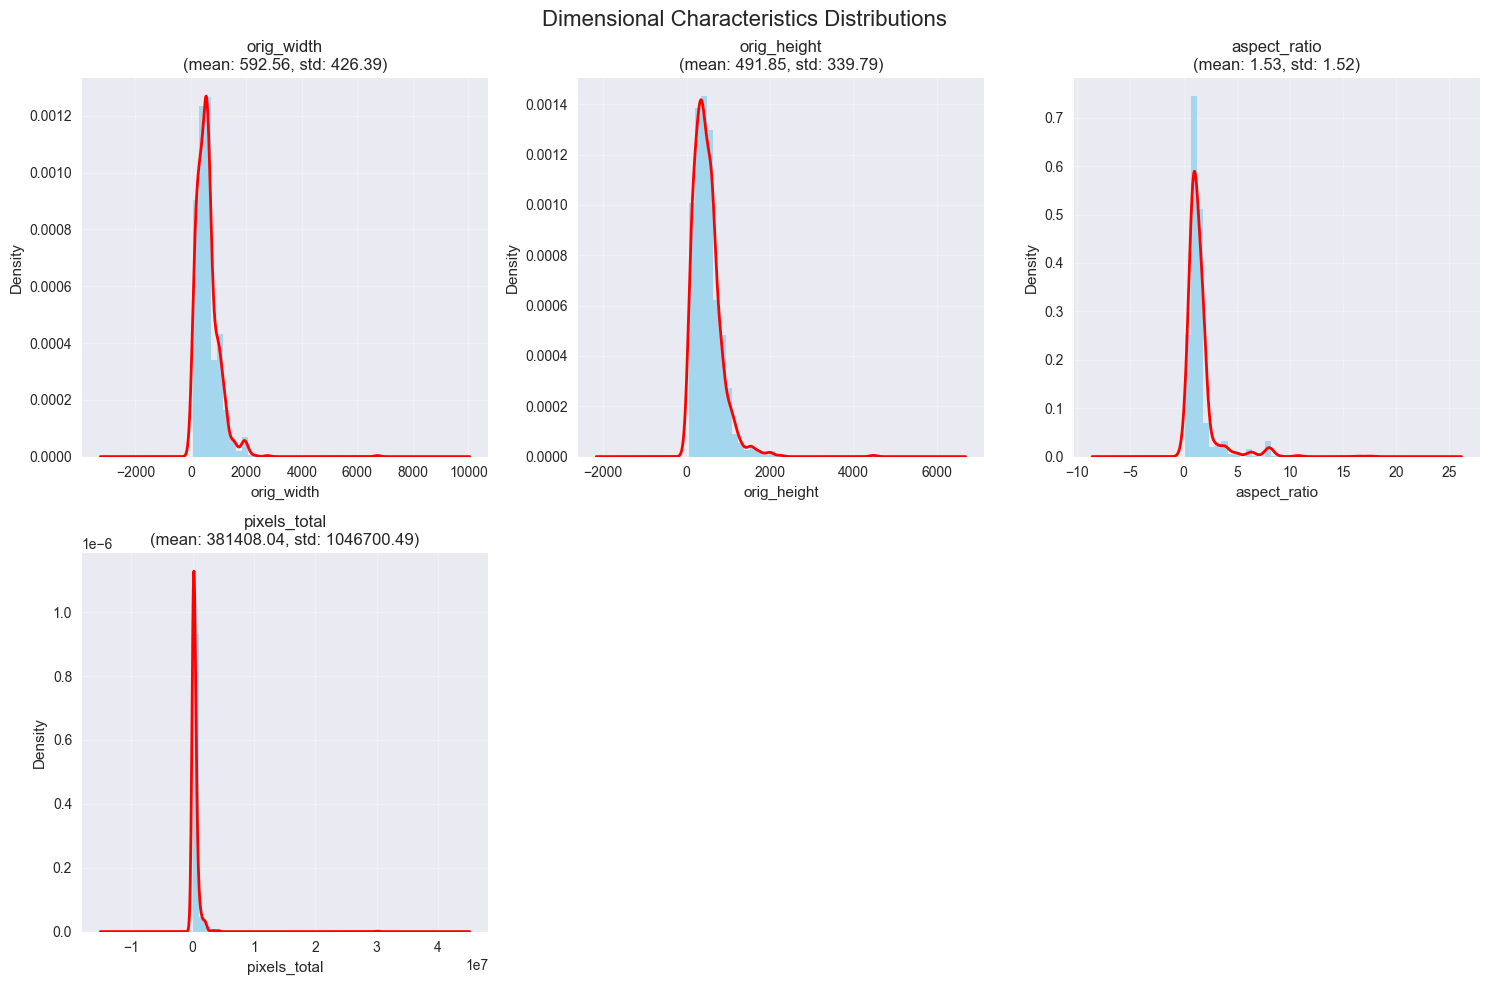

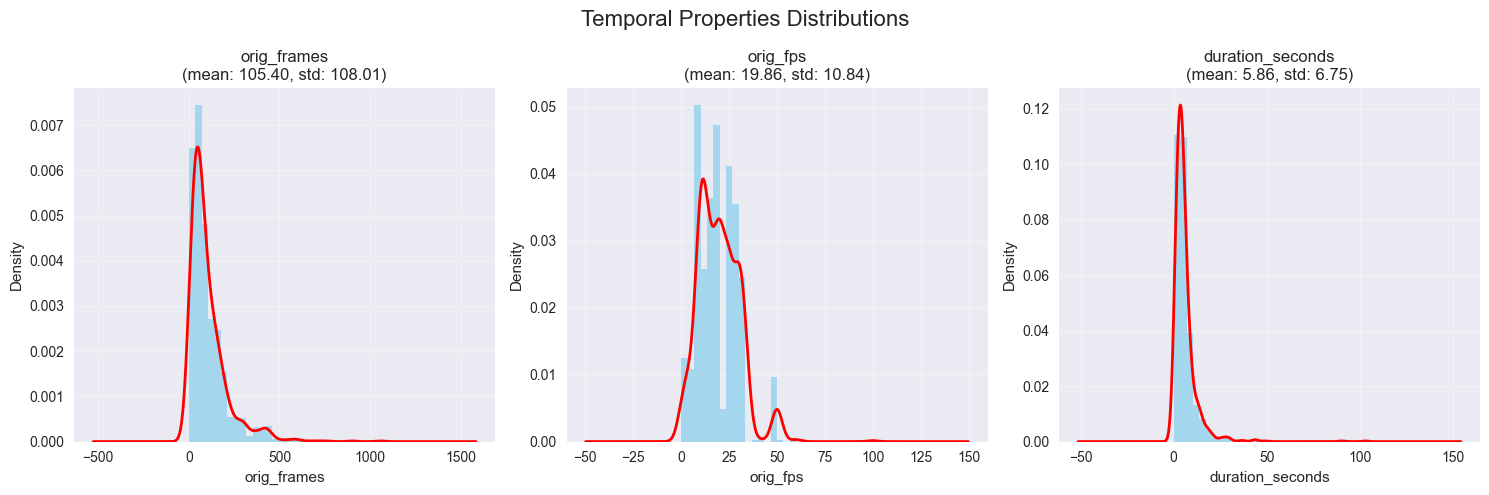

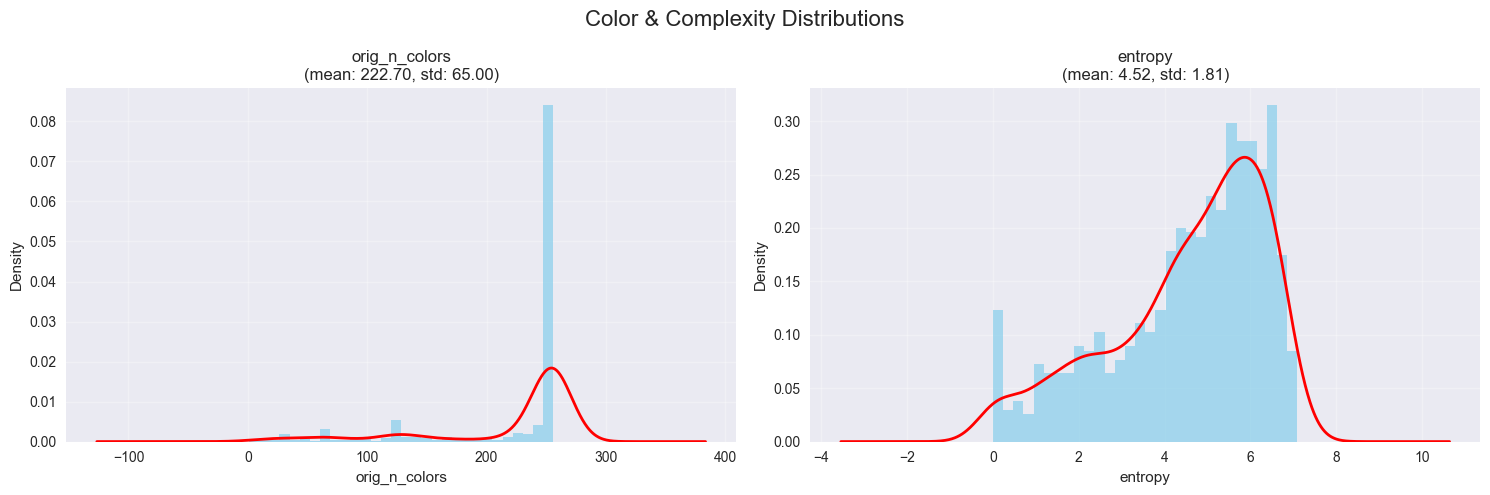

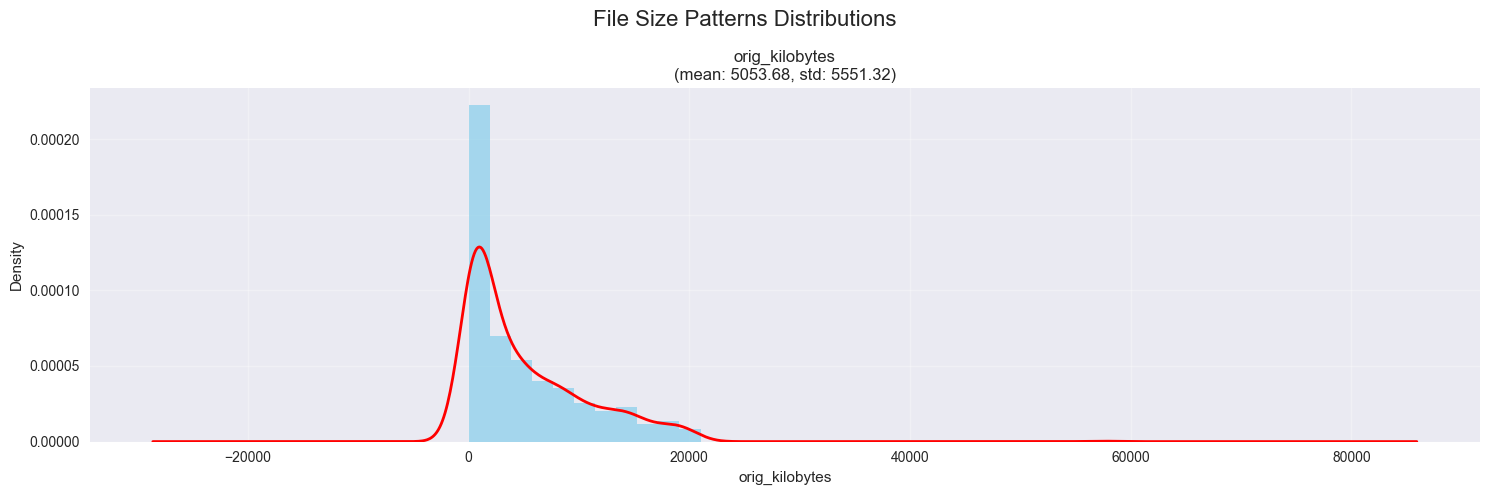

In [13]:
# Distribution visualizations
def create_distribution_plots(df: pd.DataFrame, columns: list[str], title_prefix: str = ""):
    """Create distribution plots for specified columns."""
    if df.empty:
        print("No data available for plotting")
        return

    n_cols = len(columns)
    if n_cols == 0:
        return

    # Calculate subplot layout
    n_rows = (n_cols + 2) // 3  # 3 columns per row
    n_plot_cols = min(3, n_cols)

    fig, axes = plt.subplots(n_rows, n_plot_cols, figsize=(15, 5 * n_rows))
    fig.suptitle(f'{title_prefix} Distributions', fontsize=16, y=0.98)

    # Handle single subplot case
    if n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(columns):
        if col in df.columns and not df[col].isnull().all():
            # Histogram with KDE
            axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, density=True, color='skyblue')

            # Add KDE if data is available
            try:
                df[col].dropna().plot.kde(ax=axes[i], color='red', linewidth=2)
            except:
                pass  # Skip KDE if it fails

            axes[i].set_title(f'{col}\n(mean: {df[col].mean():.2f}, std: {df[col].std():.2f})')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, f'No data for {col}', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{col} (No Data)')

    # Hide empty subplots
    for i in range(n_cols, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

if not gif_df.empty:
    # Dimensional characteristics
    dimension_cols = ['orig_width', 'orig_height', 'aspect_ratio', 'pixels_total']
    available_dim_cols = [col for col in dimension_cols if col in gif_df.columns]
    if available_dim_cols:
        create_distribution_plots(gif_df, available_dim_cols, "Dimensional Characteristics")

    # Temporal properties
    temporal_cols = ['orig_frames', 'orig_fps', 'duration_seconds']
    available_temp_cols = [col for col in temporal_cols if col in gif_df.columns]
    if available_temp_cols:
        create_distribution_plots(gif_df, available_temp_cols, "Temporal Properties")

    # Color and complexity
    color_cols = ['orig_n_colors', 'entropy']
    available_color_cols = [col for col in color_cols if col in gif_df.columns]
    if available_color_cols:
        create_distribution_plots(gif_df, available_color_cols, "Color & Complexity")

    # File size patterns
    size_cols = ['orig_kilobytes']
    available_size_cols = [col for col in size_cols if col in gif_df.columns]
    if available_size_cols:
        create_distribution_plots(gif_df, available_size_cols, "File Size Patterns")

else:
    print("📝 No data available for distribution analysis")


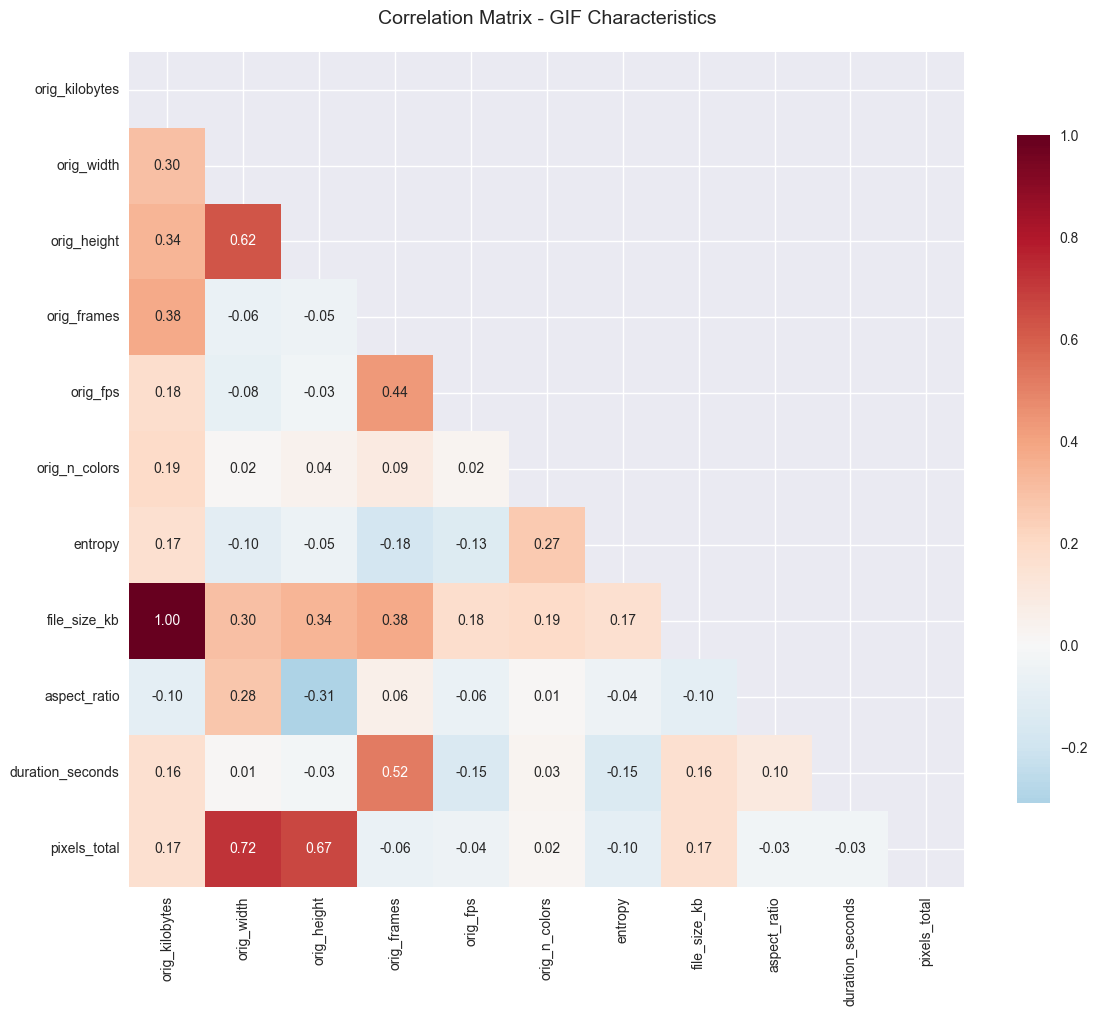

🔍 Strongest Correlations (|r| > 0.5):
   • orig_kilobytes ↔ file_size_kb: 1.000 (positive)
   • orig_width ↔ pixels_total: 0.724 (positive)
   • orig_height ↔ pixels_total: 0.666 (positive)
   • orig_width ↔ orig_height: 0.622 (positive)
   • orig_frames ↔ duration_seconds: 0.517 (positive)


In [14]:
def create_correlation_analysis(df: pd.DataFrame):
    """Create comprehensive correlation analysis."""
    if df.empty:
        print("No data available for correlation analysis")
        return

    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(numeric_cols) < 2:
        print("Need at least 2 numeric columns for correlation analysis")
        return

    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()

    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'shrink': 0.8})

    plt.title('Correlation Matrix - GIF Characteristics', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Find strongest correlations
    print("🔍 Strongest Correlations (|r| > 0.5):")
    print("=" * 40)

    # Get upper triangle of correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find correlations above threshold
    strong_corrs = []
    for col in upper_tri.columns:
        for idx in upper_tri.index:
            value = upper_tri.loc[idx, col]
            if pd.notna(value) and abs(value) > 0.5:
                strong_corrs.append((idx, col, value))

    # Sort by absolute correlation value
    strong_corrs.sort(key=lambda x: abs(x[2]), reverse=True)

    if strong_corrs:
        for var1, var2, corr_val in strong_corrs:
            direction = "positive" if corr_val > 0 else "negative"
            print(f"   • {var1} ↔ {var2}: {corr_val:.3f} ({direction})")
    else:
        print("   • No correlations with |r| > 0.5 found")

    return corr_matrix

if not gif_df.empty:
    correlation_matrix = create_correlation_analysis(gif_df)
else:
    print("📝 No data available for correlation analysis")


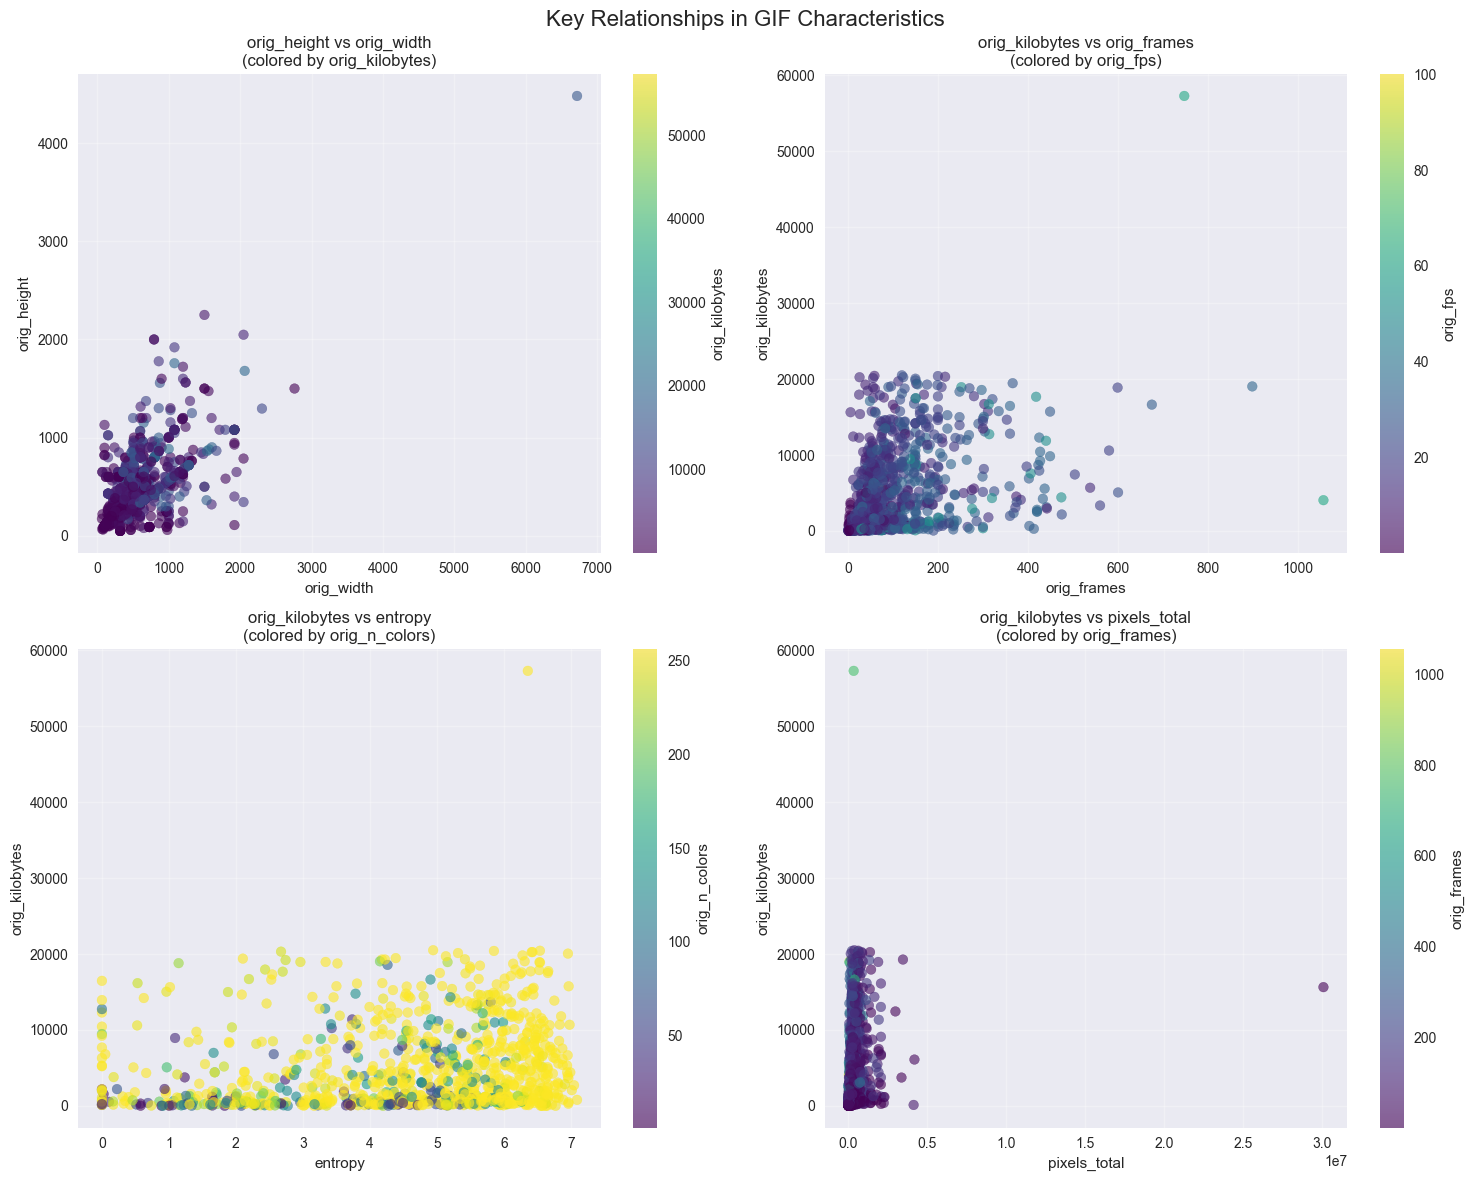

In [15]:
# Scatter plots for key relationships
def create_scatter_plots(df: pd.DataFrame):
    """Create scatter plots for key relationships."""
    if df.empty:
        print("No data available for scatter plots")
        return

    # Define key relationships to explore
    relationships = [
        ('orig_width', 'orig_height', 'orig_kilobytes'),
        ('orig_frames', 'orig_kilobytes', 'orig_fps'),
        ('entropy', 'orig_kilobytes', 'orig_n_colors'),
        ('pixels_total', 'orig_kilobytes', 'orig_frames')
    ]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Key Relationships in GIF Characteristics', fontsize=16)
    axes = axes.flatten()

    for i, (x_col, y_col, color_col) in enumerate(relationships):
        if all(col in df.columns for col in [x_col, y_col, color_col]):
            scatter = axes[i].scatter(df[x_col], df[y_col],
                                    c=df[color_col],
                                    alpha=0.6,
                                    cmap='viridis')
            axes[i].set_xlabel(x_col)
            axes[i].set_ylabel(y_col)
            axes[i].set_title(f'{y_col} vs {x_col}\n(colored by {color_col})')
            axes[i].grid(True, alpha=0.3)

            # Add colorbar
            plt.colorbar(scatter, ax=axes[i], label=color_col)
        else:
            axes[i].text(0.5, 0.5, f'Data not available\nfor {x_col}, {y_col}, {color_col}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{y_col} vs {x_col} (No Data)')

    plt.tight_layout()
    plt.show()

if not gif_df.empty:
    create_scatter_plots(gif_df)
else:
    print("📝 No data available for scatter plot analysis")


📊 Clustering Results (3 clusters):

🔍 Cluster 0 (518 GIFs):
   • Avg orig_width: 452.29
   • Avg orig_height: 376.38
   • Avg orig_frames: 72.26
   • Avg orig_fps: 17.77
   • Avg orig_n_colors: 250.40
   • Avg entropy: 4.87
   • Avg orig_kilobytes: 2547.43

🔍 Cluster 1 (309 GIFs):
   • Avg orig_width: 835.14
   • Avg orig_height: 705.61
   • Avg orig_frames: 180.12
   • Avg orig_fps: 24.17
   • Avg orig_n_colors: 247.44
   • Avg entropy: 4.41
   • Avg orig_kilobytes: 10712.89

🔍 Cluster 2 (166 GIFs):
   • Avg orig_width: 578.68
   • Avg orig_height: 454.28
   • Avg orig_frames: 69.74
   • Avg orig_fps: 18.33
   • Avg orig_n_colors: 90.25
   • Avg entropy: 3.65
   • Avg orig_kilobytes: 2340.12


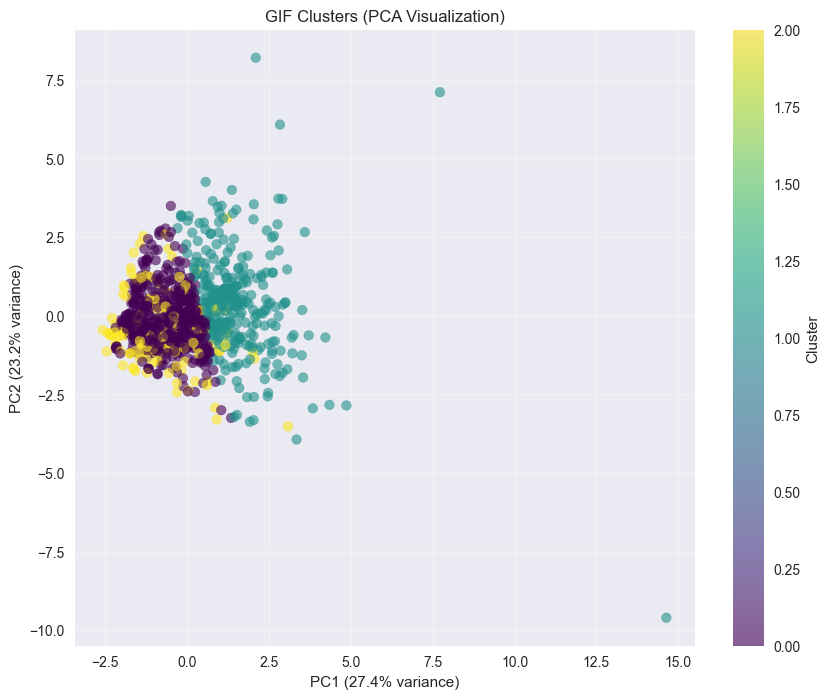


📈 PCA Explained Variance:
   • PC1: 27.4%
   • PC2: 23.2%
   • Total: 50.6%


In [16]:
def perform_clustering_analysis(df: pd.DataFrame, n_clusters: int = 3):
    """Perform K-means clustering on GIF characteristics."""
    if df.empty:
        print("No data available for clustering analysis")
        return None

    # Select features for clustering
    feature_cols = ['orig_width', 'orig_height', 'orig_frames', 'orig_fps',
                   'orig_n_colors', 'entropy', 'orig_kilobytes']

    available_features = [col for col in feature_cols if col in df.columns]

    if len(available_features) < 3:
        print(f"Need at least 3 features for clustering. Available: {available_features}")
        return None

    # Prepare data for clustering
    cluster_data = df[available_features].copy()

    # Handle missing values
    cluster_data = cluster_data.fillna(cluster_data.median())

    # Standardize features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)

    # Perform K-means clustering
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels

    print(f"📊 Clustering Results ({n_clusters} clusters):")
    print("=" * 40)

    # Analyze clusters
    for cluster_id in range(n_clusters):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        print(f"\n🔍 Cluster {cluster_id} ({len(cluster_data)} GIFs):")

        if not cluster_data.empty:
            for feature in available_features:
                mean_val = cluster_data[feature].mean()
                print(f"   • Avg {feature}: {mean_val:.2f}")

    # Visualize clusters using PCA
    from sklearn.decomposition import PCA

    if len(available_features) >= 2:
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(scaled_data)

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1],
                            c=cluster_labels, cmap='viridis', alpha=0.6)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.title('GIF Clusters (PCA Visualization)')
        plt.colorbar(scatter, label='Cluster')
        plt.grid(True, alpha=0.3)
        plt.show()

        print("\n📈 PCA Explained Variance:")
        print(f"   • PC1: {pca.explained_variance_ratio_[0]:.1%}")
        print(f"   • PC2: {pca.explained_variance_ratio_[1]:.1%}")
        print(f"   • Total: {sum(pca.explained_variance_ratio_):.1%}")

    return df_clustered

if not gif_df.empty:
    clustered_df = perform_clustering_analysis(gif_df, n_clusters=3)
else:
    print("📝 No data available for clustering analysis")
    clustered_df = None


📊 Complexity Classification Results:
   • medium_complexity: 674 GIFs (67.9%)
   • high_complexity: 226 GIFs (22.8%)
   • low_complexity: 93 GIFs (9.4%)


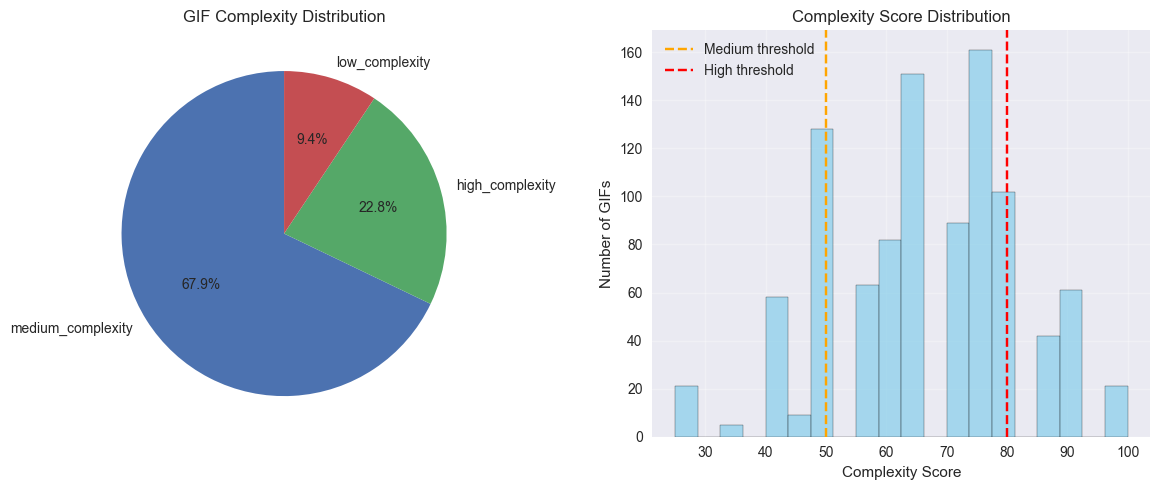

🎯 Compression Parameter Recommendations:

🔍 LOW_COMPLEXITY (93 GIFs):
   Description: Simple GIFs with low entropy, few frames, small dimensions
   Recommended lossy levels: [0, 40]
   Recommended frame ratios: [1.0, 0.8]
   Recommended color counts: [256, 128]
   Optimal batch size: 200
   Processing priority: low

🔍 MEDIUM_COMPLEXITY (674 GIFs):
   Description: Moderate complexity GIFs with average characteristics
   Recommended lossy levels: [0, 40, 80]
   Recommended frame ratios: [1.0, 0.8, 0.6]
   Recommended color counts: [256, 128, 64]
   Optimal batch size: 100
   Processing priority: medium

🔍 HIGH_COMPLEXITY (226 GIFs):
   Description: Complex GIFs with high entropy, many frames, large dimensions
   Recommended lossy levels: [0, 40]
   Recommended frame ratios: [1.0, 0.8, 0.6, 0.4]
   Recommended color counts: [256, 128, 64]
   Optimal batch size: 50
   Processing priority: high


In [17]:
def classify_gif_complexity(df: pd.DataFrame) -> pd.DataFrame:
    """Classify GIFs by processing complexity based on characteristics."""
    if df.empty:
        print("No data available for complexity classification")
        return df

    def calculate_complexity_score(row):
        """Calculate complexity score for a single GIF."""
        score = 0

        # Entropy contribution (0-40 points)
        entropy = row.get('entropy', 0)
        if entropy > 6:
            score += 40
        elif entropy > 4:
            score += 25
        else:
            score += 10

        # Frame count contribution (0-30 points)
        frames = row.get('orig_frames', 1)
        if frames > 50:
            score += 30
        elif frames > 20:
            score += 20
        else:
            score += 5

        # Dimension contribution (0-30 points)
        pixels = row.get('pixels_total', 0)
        if pixels > 500000:  # ~720p
            score += 30
        elif pixels > 200000:  # ~480p
            score += 20
        else:
            score += 10

        return score

    # Calculate complexity scores
    df_with_complexity = df.copy()
    df_with_complexity['complexity_score'] = df.apply(calculate_complexity_score, axis=1)

    # Classify based on thresholds
    def classify_complexity(score):
        if score >= 80:
            return 'high_complexity'
        elif score >= 50:
            return 'medium_complexity'
        else:
            return 'low_complexity'

    df_with_complexity['complexity_category'] = df_with_complexity['complexity_score'].apply(classify_complexity)

    # Analyze complexity distribution
    complexity_counts = df_with_complexity['complexity_category'].value_counts()

    print("📊 Complexity Classification Results:")
    print("=" * 40)
    for category, count in complexity_counts.items():
        percentage = (count / len(df_with_complexity)) * 100
        print(f"   • {category}: {count} GIFs ({percentage:.1f}%)")

    # Visualize complexity distribution
    plt.figure(figsize=(12, 5))

    # Complexity distribution pie chart
    plt.subplot(1, 2, 1)
    plt.pie(complexity_counts.values, labels=complexity_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('GIF Complexity Distribution')

    # Complexity score histogram
    plt.subplot(1, 2, 2)
    plt.hist(df_with_complexity['complexity_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=50, color='orange', linestyle='--', label='Medium threshold')
    plt.axvline(x=80, color='red', linestyle='--', label='High threshold')
    plt.xlabel('Complexity Score')
    plt.ylabel('Number of GIFs')
    plt.title('Complexity Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_with_complexity

def generate_compression_recommendations(df: pd.DataFrame):
    """Generate compression parameter recommendations based on GIF characteristics."""
    if df.empty or 'complexity_category' not in df.columns:
        print("No complexity data available for recommendations")
        return

    print("🎯 Compression Parameter Recommendations:")
    print("=" * 50)

    recommendations = {
        'low_complexity': {
            'description': 'Simple GIFs with low entropy, few frames, small dimensions',
            'recommended_lossy': [0, 40],
            'recommended_frame_ratios': [1.0, 0.8],
            'recommended_colors': [256, 128],
            'batch_size': 200,
            'processing_priority': 'low'
        },
        'medium_complexity': {
            'description': 'Moderate complexity GIFs with average characteristics',
            'recommended_lossy': [0, 40, 80],
            'recommended_frame_ratios': [1.0, 0.8, 0.6],
            'recommended_colors': [256, 128, 64],
            'batch_size': 100,
            'processing_priority': 'medium'
        },
        'high_complexity': {
            'description': 'Complex GIFs with high entropy, many frames, large dimensions',
            'recommended_lossy': [0, 40],
            'recommended_frame_ratios': [1.0, 0.8, 0.6, 0.4],
            'recommended_colors': [256, 128, 64],
            'batch_size': 50,
            'processing_priority': 'high'
        }
    }

    for category, rec in recommendations.items():
        category_count = (df['complexity_category'] == category).sum()
        print(f"\n🔍 {category.upper()} ({category_count} GIFs):")
        print(f"   Description: {rec['description']}")
        print(f"   Recommended lossy levels: {rec['recommended_lossy']}")
        print(f"   Recommended frame ratios: {rec['recommended_frame_ratios']}")
        print(f"   Recommended color counts: {rec['recommended_colors']}")
        print(f"   Optimal batch size: {rec['batch_size']}")
        print(f"   Processing priority: {rec['processing_priority']}")

if not gif_df.empty:
    # Classify complexity
    gif_df_with_complexity = classify_gif_complexity(gif_df)

    # Generate recommendations
    generate_compression_recommendations(gif_df_with_complexity)
else:
    print("📝 No data available for complexity analysis")
    gif_df_with_complexity = gif_df


In [18]:
def generate_final_insights(df: pd.DataFrame, scan_results: dict[str, Any]):
    """Generate final insights and recommendations based on analysis."""

    print("📋 GIFLAB DATASET EXPLORATION - FINAL INSIGHTS")
    print("=" * 60)

    # Dataset Overview Insights
    print("\n🔍 DATASET OVERVIEW:")
    print(f"   • Total GIF files discovered: {scan_results.get('total_files_found', 0)}")
    print(f"   • Successfully analyzed: {len(df)} GIFs")
    print(f"   • Corrupted/unreadable: {len(scan_results.get('corrupted_gifs', []))}")
    print(f"   • Success rate: {scan_results.get('success_rate', 0):.1%}")

    if not df.empty:
        # Statistical Insights
        print("\n📊 KEY CHARACTERISTICS:")

        if 'orig_kilobytes' in df.columns:
            size_stats = df['orig_kilobytes'].describe()
            print(f"   • File sizes: {size_stats['min']:.1f} - {size_stats['max']:.1f} KB (avg: {size_stats['mean']:.1f} KB)")

        if 'orig_width' in df.columns and 'orig_height' in df.columns:
            common_widths = df['orig_width'].value_counts().head(3)
            common_heights = df['orig_height'].value_counts().head(3)
            print(f"   • Common widths: {common_widths.index.tolist()}")
            print(f"   • Common heights: {common_heights.index.tolist()}")

        if 'orig_frames' in df.columns:
            frame_stats = df['orig_frames'].describe()
            print(f"   • Frame counts: {frame_stats['min']:.0f} - {frame_stats['max']:.0f} (avg: {frame_stats['mean']:.1f})")

        if 'orig_fps' in df.columns:
            fps_stats = df['orig_fps'].describe()
            print(f"   • FPS range: {fps_stats['min']:.1f} - {fps_stats['max']:.1f} (avg: {fps_stats['mean']:.1f})")

        # Complexity Distribution
        if 'complexity_category' in df.columns:
            complexity_dist = df['complexity_category'].value_counts()
            print("\n🎯 COMPLEXITY DISTRIBUTION:")
            for category, count in complexity_dist.items():
                percentage = (count / len(df)) * 100
                print(f"   • {category}: {count} GIFs ({percentage:.1f}%)")

    # Actionable Recommendations
    print("\n🚀 ACTIONABLE RECOMMENDATIONS:")
    print("\n   📈 PROCESSING OPTIMIZATION:")
    print("      • Use complexity-based batching for parallel processing")
    print("      • Prioritize high-complexity GIFs for quality retention")
    print("      • Apply aggressive compression to low-complexity GIFs")

    print("\n   ⚙️  PARAMETER TUNING:")
    print("      • Low complexity: Focus on frame reduction and color optimization")
    print("      • Medium complexity: Balanced approach with moderate lossy compression")
    print("      • High complexity: Conservative lossy settings, preserve frames")

    print("\n   🔧 PIPELINE OPTIMIZATION:")
    print("      • Implement resume functionality using GIF SHA hashes")
    print("      • Use metadata caching to avoid recomputation")
    print("      • Monitor processing time per complexity category")

    print("\n   📊 QUALITY THRESHOLDS:")
    print("      • Target SSIM > 0.9 for high-complexity GIFs")
    print("      • Accept SSIM > 0.8 for medium-complexity GIFs")
    print("      • Allow SSIM > 0.7 for low-complexity GIFs")

    # Next Steps
    print("\n📝 NEXT STEPS:")
    print("   1. Implement seed JSON generation (notebook 02)")
    print("   2. Create complexity-based processing batches")
    print("   3. Develop parameter recommendation system")
    print("   4. Set up monitoring for processing performance")
    print("   5. Validate recommendations with compression results")

# Generate final insights
generate_final_insights(gif_df_with_complexity if 'gif_df_with_complexity' in locals() else gif_df, scan_results)

# Save analysis results for use in seed generation
analysis_results = {
    'timestamp': datetime.now().isoformat(),
    'config': ANALYSIS_CONFIG,
    'scan_results': {
        'total_files_found': scan_results.get('total_files_found', 0),
        'files_analyzed': scan_results.get('files_analyzed', 0),
        'valid_gifs': len(scan_results.get('valid_gifs', [])),
        'corrupted_gifs': len(scan_results.get('corrupted_gifs', [])),
        'success_rate': scan_results.get('success_rate', 0)
    }
}

if not gif_df.empty:
    analysis_results['dataset_stats'] = {
        'total_gifs_analyzed': len(gif_df),
        'avg_file_size_kb': gif_df.get('orig_kilobytes', pd.Series()).mean(),
        'avg_frames': gif_df.get('orig_frames', pd.Series()).mean(),
        'avg_fps': gif_df.get('orig_fps', pd.Series()).mean(),
        'complexity_distribution': gif_df.get('complexity_category', pd.Series()).value_counts().to_dict() if 'complexity_category' in gif_df.columns else {}
    }

# Save results to JSON for use in seed generation
results_path = Path("../notebooks/exploration_results.json")
with open(results_path, 'w') as f:
    json.dump(analysis_results, f, indent=2, default=str)

print(f"\n💾 Analysis results saved to: {results_path}")
print("\n✅ Dataset exploration complete! Ready for seed generation (notebook 02).")


📋 GIFLAB DATASET EXPLORATION - FINAL INSIGHTS

🔍 DATASET OVERVIEW:
   • Total GIF files discovered: 8924
   • Successfully analyzed: 993 GIFs
   • Corrupted/unreadable: 7
   • Success rate: 99.3%

📊 KEY CHARACTERISTICS:
   • File sizes: 9.6 - 57293.7 KB (avg: 5053.7 KB)
   • Common widths: [600, 650, 300]
   • Common heights: [600, 250, 650]
   • Frame counts: 1 - 1056 (avg: 105.4)
   • FPS range: 0.2 - 100.0 (avg: 19.9)

🎯 COMPLEXITY DISTRIBUTION:
   • medium_complexity: 674 GIFs (67.9%)
   • high_complexity: 226 GIFs (22.8%)
   • low_complexity: 93 GIFs (9.4%)

🚀 ACTIONABLE RECOMMENDATIONS:

   📈 PROCESSING OPTIMIZATION:
      • Use complexity-based batching for parallel processing
      • Prioritize high-complexity GIFs for quality retention
      • Apply aggressive compression to low-complexity GIFs

   ⚙️  PARAMETER TUNING:
      • Low complexity: Focus on frame reduction and color optimization
      • Medium complexity: Balanced approach with moderate lossy compression
      • Hi

In [ ]:
# This cell is no longer needed - imports are handled in Cell 2 above
print("✅ All imports and analysis are complete!")
print("📊 See cells 2-17 above for the full dataset exploration implementation.")
print("🎯 This notebook provides comprehensive GIF analysis and optimization recommendations.")


In [ ]:
print("🎉 Dataset Exploration Implementation Complete!")
print("=" * 55)
print("✅ Stage 10 cleanup: Replaced placeholder content with full implementation")
print("📊 This notebook now provides comprehensive GIF dataset analysis")
print("🔧 Generates optimization recommendations for compression pipeline")
print("💾 Saves analysis results for use in seed generation")
print("\n🚀 Ready for production use!")
print("📝 Next: Run notebook 02 to build optimization seed files")


Dataset exploration notebook - to be implemented in Stage 10
